# Model Explainability 

This notebook aims at showing the model explainability for the solution.

This note book is divided into multiple sections:
1. Understand the error per hierarchy level
2. Understand the error over time
3. Understand the error using SHAPS

## 00. Set up

The set up steps consist of: 
1. Import the packages to be used. 
2. Load the model to analyze.

In [44]:
# Import required libraries
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)
from src.core.config_loader import ConfigLoader
from src.core.clients.bigquery import BigQueryClient
%matplotlib inline

bq_client = BigQueryClient()
config_loader = ConfigLoader()

INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines


In [45]:
from src.core.models.xgboost import XgboostModel

model = XgboostModel().load_model(
    '/Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260130_182026_foods/model_0.pickle'
)
type(model)

INFO:src.core.models.xgboost:Model loaded from /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260130_182026_foods/model_0.pickle


src.core.models.xgboost.XgboostModel

## 0.1 Understanding the error per hierarchy level

In [46]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, median_absolute_error, mean_pinball_loss

def error_for_group(group):
    group["actuals"] = np.expm1(group[config_loader.target_col])
    group["benchmark"] = np.expm1(group[config_loader.benchmark_col])
    group["predictions"] = model.predict(group[model.features], True)

    # group["actuals"] = group[config_loader.target_col]
    # group["benchmark"] = group[config_loader.benchmark_col]
    # group["predictions"] = model.predict(group[model.features], False)

    return pd.Series({
        "pred_mae": mean_absolute_error(group["actuals"], group["predictions"]),
        "bench_mae": mean_absolute_error(group["actuals"], group["benchmark"]),
        "diff_mae": (
            mean_absolute_error(group["actuals"], group["predictions"])
            - mean_absolute_error(group["actuals"], group["benchmark"])
        ),
        "pred_rsme": root_mean_squared_error(group["actuals"], group["predictions"]),
        "bench_rsme": root_mean_squared_error(group["actuals"], group["benchmark"]),
        "diff_rsme": (
            root_mean_squared_error(group["actuals"], group["predictions"])
            - root_mean_squared_error(group["actuals"], group["benchmark"])
        ),
        "pred_mdae": median_absolute_error(group["actuals"], group["predictions"]),
        "bench_mdae": median_absolute_error(group["actuals"], group["benchmark"]),
        "diff_mdae": (
            median_absolute_error(group["actuals"], group["predictions"])
            - median_absolute_error(group["actuals"], group["benchmark"])
        ),
        "pred_mape": mean_absolute_percentage_error(group["actuals"], group["predictions"]),
        "bench_mape": mean_absolute_percentage_error(group["actuals"], group["benchmark"]),
        "diff_mape": (
            mean_absolute_percentage_error(group["actuals"], group["predictions"])
            - mean_absolute_percentage_error(group["actuals"], group["benchmark"])
        ),
        "pred_mdape": (abs(group["predictions"]-group["actuals"])/group["actuals"]).quantile(.50),
        "bench_mdape": (abs(group["benchmark"]-group["actuals"])/group["actuals"]).quantile(.50),
        "diff_mdape": ((abs(group["predictions"]-group["actuals"])/group["actuals"])).quantile(.50)
            - (abs(group["benchmark"]-group["actuals"])/group["actuals"]).quantile(.50)
        })

def retrieve_error_per_group(df, groupby_col):
    df = df.copy()

    return df.groupby(groupby_col).apply(lambda group: error_for_group(group))



In [47]:
metrics_df = pd.DataFrame(error_for_group(model.validation_df))
display(metrics_df)

,0
pred_mae,35.874344
bench_mae,44.795111
diff_mae,-8.920767
pred_rsme,60.406317
bench_rsme,85.970056
diff_rsme,-25.563739
pred_mdae,20.125961
bench_mdae,24.000000
diff_mdae,-3.874039
pred_mape,0.258313


In [48]:
metrics_df = pd.DataFrame(error_for_group(model.training_df))
display(metrics_df)

,0
pred_mae,41.713376
bench_mae,57.816601
diff_mae,-16.103225
pred_rsme,70.938506
bench_rsme,107.335801
diff_rsme,-36.397294
pred_mdae,22.182018
bench_mdae,29.000000
diff_mdae,-6.817982
pred_mape,0.242102


In [49]:
display(retrieve_error_per_group(model.validation_df, "ctx_cat_id"))
display(retrieve_error_per_group(model.training_df, "ctx_cat_id"))


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_70260/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape,pred_mdape,bench_mdape,diff_mdape
ctx_cat_id,,,,,,,,,,,,,,,
FOODS,35.874344,44.795111,-8.920767,60.406317,85.970056,-25.563739,20.125961,24.0,-3.874039,0.258313,0.311526,-0.053213,0.183929,0.219819,-0.03589


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_70260/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape,pred_mdape,bench_mdape,diff_mdape
ctx_cat_id,,,,,,,,,,,,,,,
FOODS,41.713376,57.816601,-16.103225,70.938506,107.335801,-36.397294,22.182018,29.0,-6.817982,0.242102,0.317245,-0.075143,0.162534,0.221862,-0.059328


## 02. Understand the error over time


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_70260/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


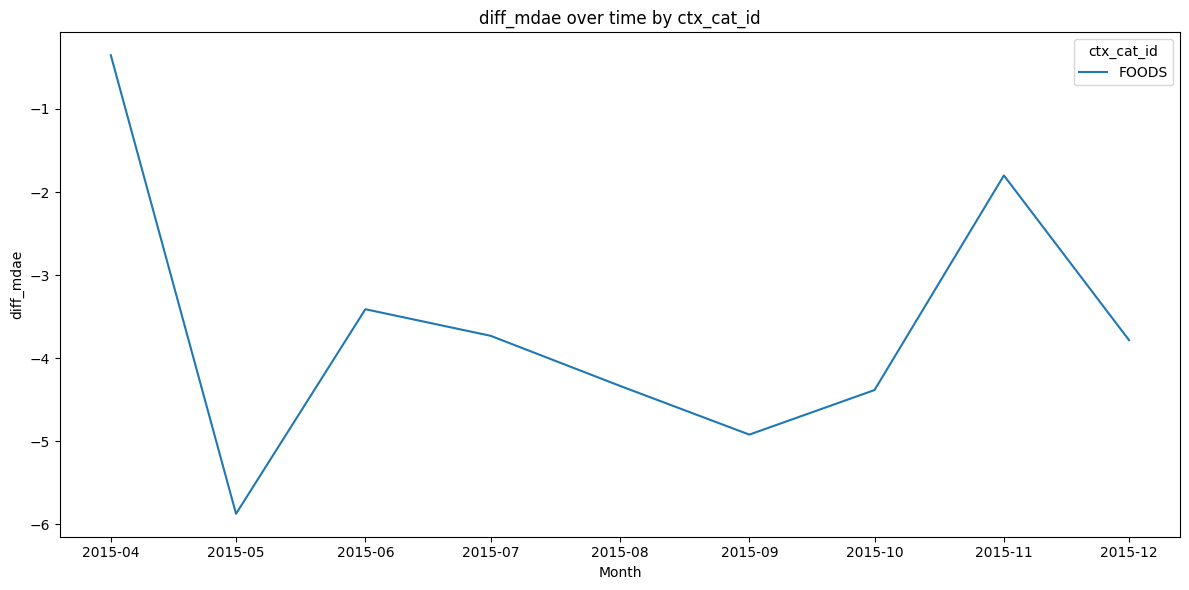

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_70260/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


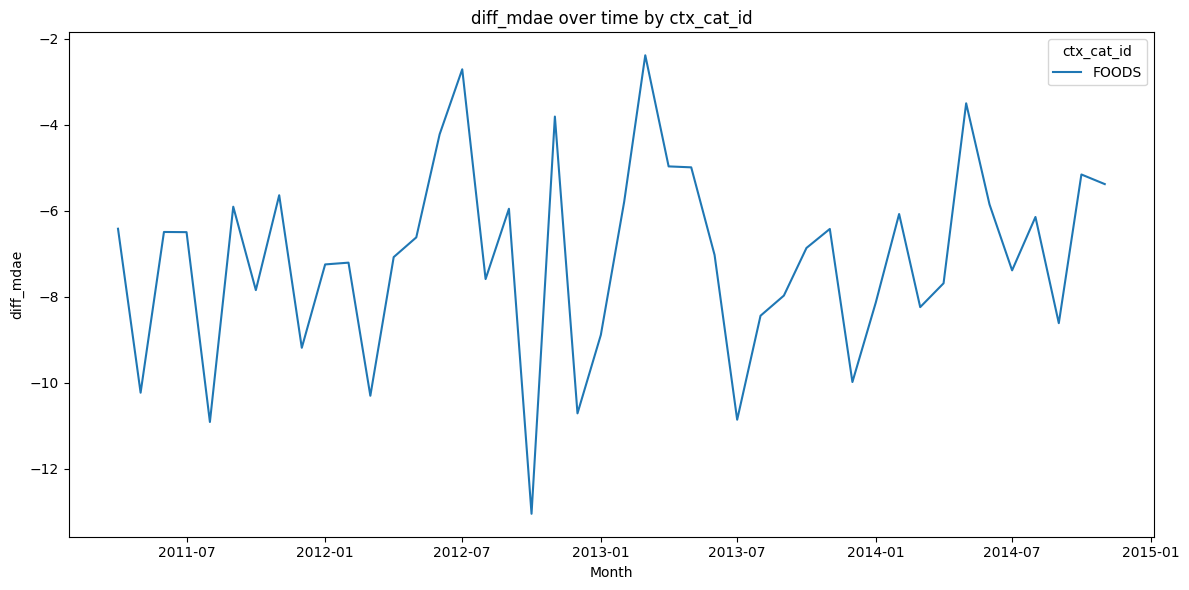

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_error_per_col(df, col_name):
    df = df.copy()
    plt.figure(figsize=(12, 6))
    for col in df[col_name].unique():
        error_over_time = retrieve_error_per_group(
            df[df[col_name]==col], 
            "ctx_date_month"
        )
        error_over_time["diff_mdae"].plot(label=str(col))
    plt.title(f"diff_mdae over time by {col_name}")
    plt.xlabel("Month")
    plt.ylabel("diff_mdae")
    plt.legend(title=col_name)
    plt.tight_layout()
    plt.show()
    
plot_error_per_col(model.validation_df, "ctx_cat_id")
plot_error_per_col(model.training_df, "ctx_cat_id")

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_70260/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


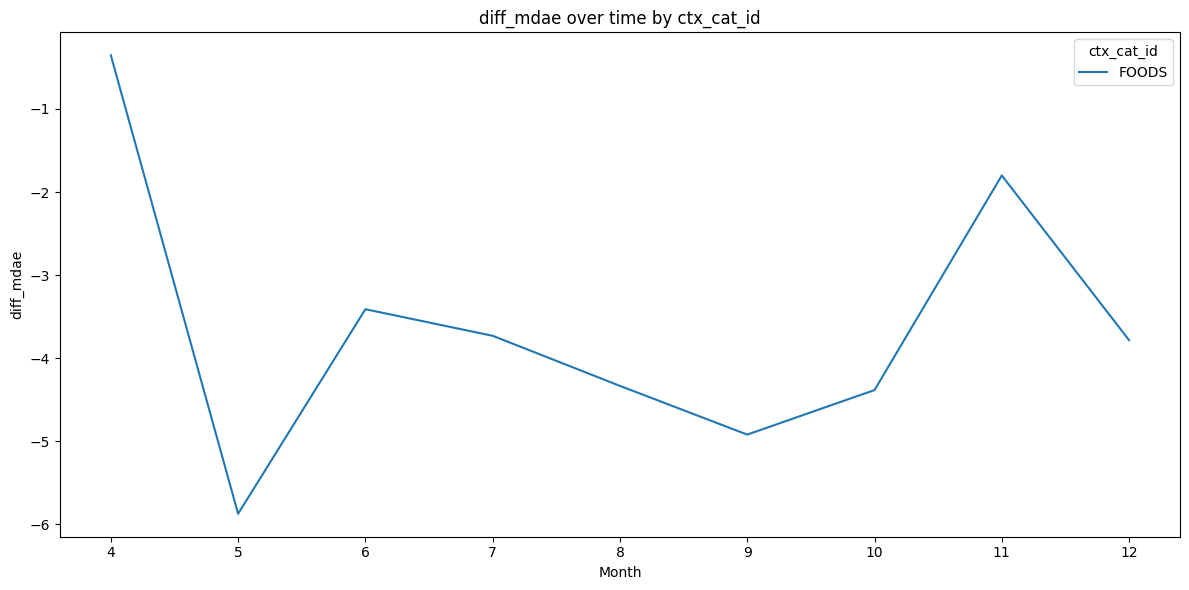

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_70260/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


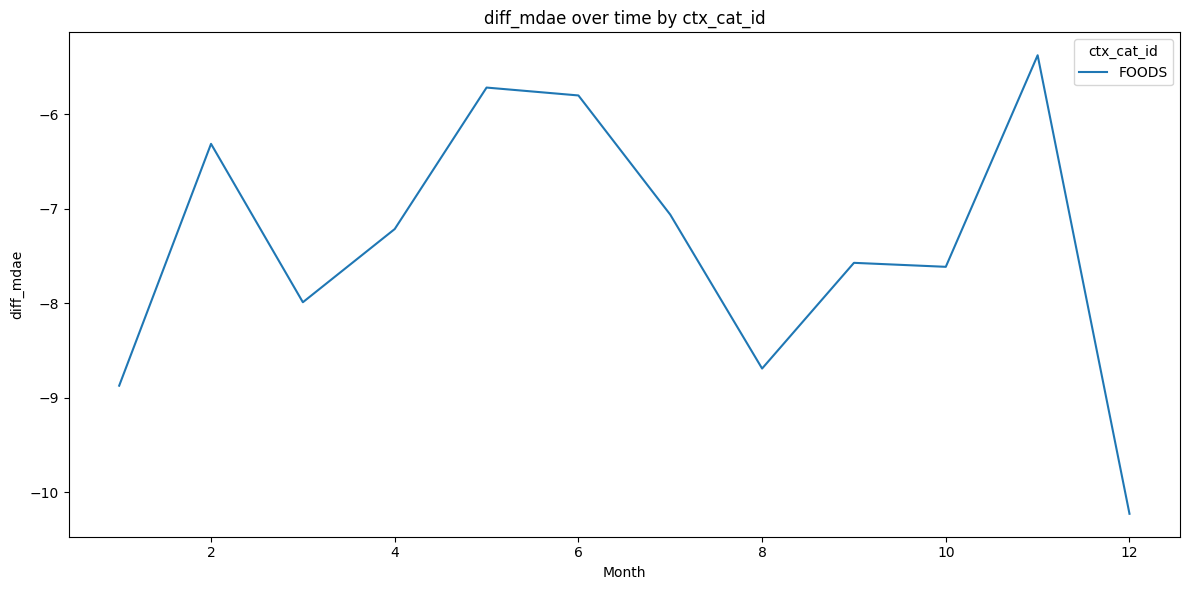

In [51]:
# Now lets look at it per month

import matplotlib.pyplot as plt
def plot_error_per_col(df, col_name):
    df = df.copy()
    df["ctx_month"] = pd.to_datetime(df['ctx_date_month']).dt.month
    plt.figure(figsize=(12, 6))
    for col in df[col_name].unique():
        error_over_time = retrieve_error_per_group(
            df[df[col_name]==col], 
            "ctx_month"
        )
        error_over_time["diff_mdae"].plot(label=str(col))
    plt.title(f"diff_mdae over time by {col_name}")
    plt.xlabel("Month")
    plt.ylabel("diff_mdae")
    plt.legend(title=col_name)
    plt.tight_layout()
    plt.show()
    
plot_error_per_col(model.validation_df, "ctx_cat_id")
plot_error_per_col(model.training_df, "ctx_cat_id")

# 04. Understand error per data completion

In [52]:
data_completion = model.training_df.groupby(["ctx_item_id"]).count()[["ctx_date_month"]].reset_index().rename(columns={"ctx_date_month": "data_completion"})

df = model.training_df.copy()
df = df.merge(data_completion, on =["ctx_item_id"], how="left")
df["completion_qs"] = pd.qcut(df["data_completion"], q=5)

In [53]:
display(retrieve_error_per_group(df, "completion_qs"))

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_70260/3212933508.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_70260/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape,pred_mdape,bench_mdape,diff_mdape
completion_qs,,,,,,,,,,,,,,,
"(0.999, 19.0]",39.233936,60.269574,-21.035638,67.661701,126.954601,-59.292901,20.722992,28.0,-7.277008,0.289147,0.377565,-0.088418,0.176226,0.260000,-0.083774
"(19.0, 28.0]",41.212546,59.010022,-17.797476,71.010766,112.784698,-41.773932,22.414169,29.0,-6.585831,0.245927,0.328629,-0.082703,0.166801,0.227273,-0.060472
"(28.0, 34.0]",44.048559,59.922438,-15.873880,73.991339,104.830303,-30.838965,22.545776,30.0,-7.454224,0.233029,0.306917,-0.073888,0.166052,0.220339,-0.054287
"(34.0, 43.0]",40.610349,54.242333,-13.631984,73.668898,98.835863,-25.166964,19.395142,26.0,-6.604858,0.232891,0.302243,-0.069352,0.165288,0.220000,-0.054712
"(43.0, 44.0]",44.007297,55.284195,-11.276898,67.873716,84.857115,-16.983399,27.609791,35.0,-7.390209,0.202186,0.260285,-0.058099,0.142072,0.184211,-0.042138


# 05. Understand error per coefficient of variation

In [54]:
df = model.validation_df.copy()
df["coeffvar_qs"] = pd.qcut(df["fea_item_monthly_sales_roll_coeffvar_12_months"], q=5)

In [55]:
display(retrieve_error_per_group(df, "coeffvar_qs"))

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_70260/3212933508.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_70260/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape,pred_mdape,bench_mdape,diff_mdape
coeffvar_qs,,,,,,,,,,,,,,,
"(0.534, 2.16]",43.895947,59.309194,-15.413247,76.097479,125.929239,-49.831759,22.610544,27.0,-4.389456,0.359762,0.440577,-0.080815,0.242916,0.302776,-0.059860
"(2.16, 2.684]",32.159791,40.160681,-8.000889,55.981444,75.833877,-19.852434,17.594223,22.0,-4.405777,0.284664,0.342751,-0.058087,0.205962,0.258824,-0.052862
"(2.684, 3.328]",31.548926,40.236925,-8.687999,54.196360,74.666982,-20.470622,17.661194,22.0,-4.338806,0.241209,0.300050,-0.058841,0.181912,0.227273,-0.045361
"(3.328, 4.3]",31.778851,38.766856,-6.988005,50.675312,67.594537,-16.919225,18.161995,22.0,-3.838005,0.220449,0.263356,-0.042906,0.171713,0.199125,-0.027412
"(4.3, 18.524]",39.983150,45.492754,-5.509604,61.751803,72.081812,-10.330009,25.022202,27.0,-1.977798,0.185417,0.210816,-0.025399,0.136866,0.151786,-0.014920


# 06. Understand item level arima scores

In [56]:
arima_scores = pd.read_csv('/Users/anapreciado/Desktop/porygon-demand-forecasting/src/notebooks/legacy_data_exploration/ts_attributes/autoarima_results_per_item.csv')

In [57]:
arima_scores.columns

Index(['Unnamed: 0', 'ctx_item_id', 'arima_orer', 'seasonal_order', 'aic',
       'arima_order_p', 'arima_order_d', 'arima_order_q', 'seasonal_order_p',
       'seasonal_order_d', 'seasonal_order_q', 'seasonal_order_m'],
      dtype='object')

In [58]:
df = model.training_df.copy()
df = df.merge(arima_scores, on = "ctx_item_id", how = "left")

In [59]:
display(df.groupby(['arima_order_d']).count())
display(retrieve_error_per_group(df, "arima_order_d"))

,ctx_item_id,ctx_date_month,ctx_cat_id,ctx_dept_id,ctx_store_id,fea_item_monthly_sales_roll_count_12_months,fea_item_monthly_sales_lag_1_months,fea_item_monthly_sales_lag_2_months,fea_item_monthly_sales_lag_3_months,fea_item_monthly_sales_lag_4_months,...,Unnamed: 0,arima_orer,seasonal_order,aic,arima_order_p,arima_order_q,seasonal_order_p,seasonal_order_d,seasonal_order_q,seasonal_order_m
arima_order_d,,,,,,,,,,,,,,,,,,,,,
0.0,14449,14449,14449,14449,14449,14449,14449,14449,14236,13793,...,14449,14449,14449,14449,14449,14449,14449,14449,14449,14449
1.0,9495,9495,9495,9495,9495,9495,9495,9495,9353,9087,...,9495,9495,9495,9495,9495,9495,9495,9495,9495,9495
2.0,5,5,5,5,5,5,5,5,5,4,...,5,5,5,5,5,5,5,5,5,5


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_70260/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape,pred_mdape,bench_mdape,diff_mdape
arima_order_d,,,,,,,,,,,,,,,
0.0,42.926053,59.752024,-16.825971,74.667564,112.149750,-37.482185,22.503242,30.0,-7.496758,0.238671,0.319793,-0.081122,0.166794,0.225410,-0.058616
1.0,40.543988,55.551975,-15.007987,66.574856,98.349145,-31.774289,22.179291,30.0,-7.820709,0.215915,0.284238,-0.068323,0.149093,0.204225,-0.055132
2.0,75.776825,62.000000,13.776825,84.676175,77.622162,7.054013,61.163879,31.0,30.163879,0.747478,0.595796,0.151682,0.815518,0.336957,0.478562


In [60]:
display(retrieve_error_per_group(df, "seasonal_order_q"))

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_70260/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape,pred_mdape,bench_mdape,diff_mdape
seasonal_order_q,,,,,,,,,,,,,,,
0.0,41.204558,56.778720,-15.574162,69.705778,103.936594,-34.230816,22.089649,29.0,-6.910351,0.229504,0.304242,-0.074738,0.159391,0.215211,-0.055820
1.0,47.155107,66.350387,-19.195280,82.534701,124.072344,-41.537643,24.603798,33.0,-8.396202,0.229889,0.312129,-0.082240,0.157696,0.219343,-0.061647
2.0,31.907753,45.688136,-13.780382,48.073369,70.661715,-22.588346,21.739334,27.0,-5.260666,0.245171,0.330322,-0.085151,0.162463,0.230769,-0.068306


## 07. Understand error in slope

In [61]:
import numpy as np

cols = [
    "fea_item_monthly_sales_lag_1_months",
    "fea_item_monthly_sales_lag_2_months",
    "fea_item_monthly_sales_lag_3_months",
    "fea_item_monthly_sales_lag_4_months",
    "fea_item_monthly_sales_lag_5_months",
    "fea_item_monthly_sales_lag_6_months",
    "fea_item_monthly_sales_lag_7_months",
    "fea_item_monthly_sales_lag_8_months",
    "fea_item_monthly_sales_lag_9_months",
    "fea_item_monthly_sales_lag_10_months",
    "fea_item_monthly_sales_lag_11_months",
    "fea_item_monthly_sales_lag_12_months"
]

X = np.arange(len(cols))
Y = df[cols].values  # shape: (n_rows, 12)
N = len(cols)

sum_x = X.sum()
sum_x2 = (X**2).sum()

sum_y = Y.sum(axis=1)
sum_xy = (Y * X).sum(axis=1)

numerator = N * sum_xy - sum_x * sum_y
denominator = N * sum_x2 - sum_x**2

slopes = numerator / denominator
df["ts_slope"] = abs(slopes)

In [62]:
df = df[~df['ts_slope'].isna()]
df["ts_slope_qs"] = pd.qcut(df["ts_slope"], q=10)
display(retrieve_error_per_group(df, "ts_slope_qs"))

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_70260/3212933508.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_70260/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape,pred_mdape,bench_mdape,diff_mdape
ts_slope_qs,,,,,,,,,,,,,,,
"(-0.001, 0.224]",23.105678,31.465018,-8.359341,41.059891,59.203094,-18.143203,12.681488,17.0,-4.318512,0.243517,0.308930,-0.065414,0.160644,0.225806,-0.065162
"(0.224, 0.444]",23.463795,31.810610,-8.346816,41.856293,55.702054,-13.845761,13.670914,19.0,-5.329086,0.240095,0.318355,-0.078260,0.160990,0.231975,-0.070985
"(0.444, 0.706]",25.447555,33.130940,-7.683385,45.492435,57.201519,-11.709084,14.640171,19.0,-4.359829,0.238575,0.304048,-0.065473,0.160531,0.220690,-0.060159
"(0.706, 1.017]",25.647233,34.707979,-9.060746,44.454999,59.302367,-14.847368,15.121872,21.0,-5.878128,0.226951,0.298702,-0.071751,0.154043,0.222222,-0.068180
"(1.017, 1.388]",29.254437,39.930814,-10.676378,49.982014,72.065069,-22.083055,17.780365,23.0,-5.219635,0.227471,0.298455,-0.070984,0.153037,0.208589,-0.055552
"(1.388, 1.871]",33.712062,45.561869,-11.849807,56.356563,77.848025,-21.491462,21.036163,27.0,-5.963837,0.230764,0.298410,-0.067645,0.161495,0.216216,-0.054722
"(1.871, 2.622]",40.978885,55.536340,-14.557454,66.585998,91.445550,-24.859552,25.001953,33.0,-7.998047,0.241929,0.307726,-0.065798,0.153159,0.211538,-0.058379
"(2.622, 3.864]",50.708653,66.507431,-15.798778,77.966055,103.176492,-25.210437,32.931190,42.0,-9.068810,0.242999,0.312658,-0.069660,0.166019,0.218002,-0.051983
"(3.864, 6.65]",64.356006,88.669321,-24.313315,92.963927,138.111995,-45.148068,43.648643,58.0,-14.351357,0.247747,0.326212,-0.078465,0.162523,0.217578,-0.055055


## 03. Define Function to Plot SHAPs

In [63]:
import xgboost as xgb

def get_shaps(df):
    df = df.copy()

    # Shap table for validation:
    shaps_dataset = df[model.features]
    matrix_observation = xgb.DMatrix(shaps_dataset)

    # Assuming your model is named 'model' and your features are in 'X_train'
    shap_values = model.model.get_booster().predict(matrix_observation, pred_contribs=True)

    # 1. SHAP values DataFrame (excluding bias)
    shap_df = pd.DataFrame(shap_values[:, :-1], columns=model.features, index=shaps_dataset.index)

    # Reshape to long format with separate columns for value and SHAP value
    feature_long = shaps_dataset.reset_index().melt(id_vars='index', value_vars=shaps_dataset.columns, var_name='feature', value_name='feature_value')
    shap_long = shap_df.reset_index().melt(id_vars='index', value_vars=shap_df.columns, var_name='feature', value_name='shap_value')
    # Merge the two long DataFrames on observation index and feature name
    merged_long_df = pd.merge(feature_long, shap_long, on=['index', 'feature'])

    # Rename 'index' to 'observation' for clarity
    merged_long_df.rename(columns={'index': 'observation'}, inplace=True)
    merged_long_df["abs_shap_value"] = abs(merged_long_df['shap_value'])

    df["predictions"] = model.predict(df[model.features])
    df["error"] = (df["predictions"] - df[config_loader.target_col])/df[config_loader.target_col]

    merged_long_df_preds = merged_long_df.merge(
        df[['predictions', 'error', 'ctx_date_month', 'ctx_dept_id', 'ctx_cat_id', 'ctx_item_id']],
        left_on='observation',
        right_index=True,
        how='left'
    )

    return merged_long_df_preds
